In [ ]:
import pandas as pd
import numpy as np
import math
from math import sqrt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

# !pip install pmdarima
import pmdarima as pm
from pmdarima import auto_arima

tweet_vaderized = pd.read_excel('data/sentitweet610.xlsx')
reddit_vaderized = pd.read_excel('data/sentireddit610.xlsx')
startDate = pd.to_datetime('20160601')
endDate = pd.to_datetime('20161001')
i_hour = pd.date_range(start=startDate, end=endDate,freq='H')

tweet_senti = tweet_vaderized.resample('H', on='dtime').mean().reindex(i_hour).fillna(0).loc[:,['vader_compound']]
redditmidsum = reddit_vaderized.resample('H', on='time').sum().reindex(i_hour).fillna(0)
redditmidsum['sentivader'] = (redditmidsum.vaderscore / redditmidsum.scoren).fillna(0)
reddit_senti =  redditmidsum.loc[:,['sentivader']]

senti = pd.concat([tweet_senti, reddit_senti], axis=1)
senti.columns = ['tweet_senti','reddit_senti']

senti['tweet_count'] = (tweet_vaderized.resample('H', on='dtime').count().loc[:,['vader_compound']])
senti['reddit_count'] = (reddit_vaderized.resample('H', on='time').sum().loc[:,['scoren']])
senti['tweet_count'] = np.log(senti['tweet_count']+1)
senti['reddit_count'] = np.log(senti['reddit_count']+1)
senti = senti.fillna(0)

senti.to_excel('data/senti610day.xlsx', index=True)

In [27]:
np.corrcoef(senti['tweet_count'],senti['tweet_senti'])

array([[ 1.        , -0.29951693],
       [-0.29951693,  1.        ]])

In [28]:
np.corrcoef(senti['reddit_count'],senti['reddit_senti'])

array([[ 1.        , -0.06152973],
       [-0.06152973,  1.        ]])

In [2]:
from arch.unitroot import ADF,DFGLS,PhillipsPerron,KPSS
print(ADF(senti['tweet_senti'].values))
print(DFGLS(senti['tweet_senti'].values))
print(PhillipsPerron(senti['tweet_senti'].values))
print(KPSS(senti['tweet_senti'].values))

   Augmented Dickey-Fuller Results   
Test Statistic                 -8.418
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
      Dickey-Fuller GLS Results      
Test Statistic                 -2.142
P-value                         0.032
Lags                               28
-------------------------------------

Trend: Constant
Critical Values: -2.57 (1%), -1.95 (5%), -1.63 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                -52.356
P-value                         0.000
Lags                               28
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Nu

In [ ]:
dates = senti.index
data = senti[['tweet_count','tweet_senti']]
data = data.fillna(0)
data.columns = ['count','senti']
data['senti'] = data['senti'].shift().fillna(0)
split_train = math.floor(len(data) * 0.2)

train = data[:-split_train]
test = data[-split_train:]

In [4]:
# kalmanData = pd.concat([senti['reddit_senti'], senti['tweet_senti']],axis=1)
# kalmanData.columns = ['reddit', 'tweet']

In [5]:
data['Sentiment Score of Posts from Twitter'] = data['senti']

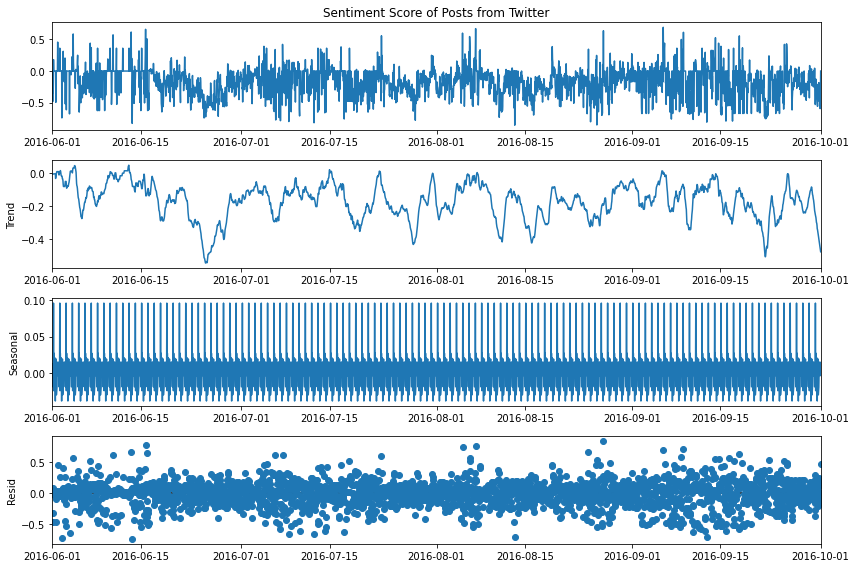

In [6]:
decomposition = sm.tsa.seasonal_decompose(data['Sentiment Score of Posts from Twitter'], model='additive', extrapolate_trend='freq')  
plt.rc('figure',figsize=(12,8))
fig = decomposition.plot()
plt.show()

In [7]:
kalmanData = pd.DataFrame(senti['tweet_senti'])
kalmanData.columns = ['Twitter']
kalmanData

,Twitter
2016-06-01 00:00:00,-0.482400
2016-06-01 01:00:00,0.000000
2016-06-01 02:00:00,-0.340000
2016-06-01 03:00:00,0.180600
2016-06-01 04:00:00,0.000000
...,...
2016-09-30 20:00:00,-0.232067
2016-09-30 21:00:00,-0.593800
2016-09-30 22:00:00,-0.472933
2016-09-30 23:00:00,0.000000


In [8]:
model = pm.auto_arima ( train['senti'], 
                        start_p=0, start_q=0, max_p=2, max_q=2, 
                        m=24, start_P=0, start_Q=0, max_P=1, max_Q=1,   
                        seasonal=False, stationary=True, 
                        trace=True, error_action='ignore', suppress_warnings=True,                         
                        stepwise=True, scoring='mse')
model.summary()

/Users/jacqualync/opt/anaconda3/lib/python3.7/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (24) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-623.638, Time=0.52 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-976.203, Time=0.40 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-857.664, Time=0.84 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=485.447, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-1107.322, Time=0.47 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1207.687, Time=1.83 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1200.393, Time=1.34 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1196.570, Time=1.46 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1205.463, Time=1.87 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1188.128, Time=0.46 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 9.308 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2344
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 608.843
Date:                Sun, 15 Aug 2021   AIC                          -1207.687
Time:                        20:16:17   BIC                          -1178.889
Sample:                             0   HQIC                         -1197.197
                               - 2344                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0056      0.002     -3.587      0.000      -0.009      -0.003
ar.L1          1.0645      0.028     37.407      0.000       1.009       1.120
ar.L2         -0.0986      0.023     -4.270      0.000      -0.144      -0.053
ma.L1         -0.8402      0.022    -38.262      0.000      -0.883      -0.797
sigma2         0.0348      0.001     47.098      0.000       0.033       0.036
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               419.98
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.22
Prob(H) (two-sided):                  0.13   Kurtosis:                         5.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
model_count = pm.auto_arima(train['senti'], X = pd.DataFrame(train['count']),
                            start_p=0, start_q=0, max_p=2, max_q=2,    
                            seasonal=False, stationary=True, 
                            trace=True, error_action='ignore', suppress_warnings=True,                         
                            stepwise=True, scoring='mse')
model_count.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-857.710, Time=0.46 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1061.480, Time=0.44 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1000.289, Time=0.84 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-806.348, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-1155.824, Time=0.84 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1217.171, Time=2.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1214.575, Time=1.49 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1210.608, Time=2.49 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1215.999, Time=2.22 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1194.536, Time=1.38 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 12.567 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2344
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 614.586
Date:                Sun, 15 Aug 2021   AIC                          -1217.171
Time:                        20:16:30   BIC                          -1182.614
Sample:                    06-01-2016   HQIC                         -1204.584
                         - 09-06-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0060      0.002     -3.518      0.000      -0.009      -0.003
count         -0.0170      0.005     -3.729      0.000      -0.026      -0.008
ar.L1          1.0238      0.033     31.261      0.000       0.960       1.088
ar.L2         -0.0757      0.024     -3.165      0.002      -0.123      -0.029
ma.L1         -0.8153      0.027    -29.928      0.000      -0.869      -0.762
sigma2         0.0346      0.001     46.957      0.000       0.033       0.036
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               418.50
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -0.26
Prob(H) (two-sided):                  0.18   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
model_seasonal = pm.auto_arima( train['senti'], 
                                start_p=0, start_q=0, max_p=2, max_q=2, 
                                m=24, start_P=0, start_Q=0, max_P=1, max_Q=1,           
                                stationary=True, seasonal=True, 
                                trace=True, error_action='ignore', suppress_warnings=True,                         
                                stepwise=True, scoring='mse')
model_seasonal.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-623.638, Time=0.24 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-996.453, Time=2.39 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-890.047, Time=1.97 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=485.447, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-976.203, Time=0.38 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=-1011.627, Time=7.59 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=-993.763, Time=1.76 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=-708.064, Time=4.50 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=-1128.927, Time=7.71 sec
 ARIMA(2,0,0)(0,0,1)[24] intercept   : AIC=-1115.165, Time=2.23 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=-1116.181, Time=5.31 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=-1107.322, Time=0.37 sec
 ARIMA(2,0,1)(1,0,1)[24] intercept   : AIC=-1212.718, Time=8.28 sec
 ARIMA(2,0,1)(0,0,1)[24] intercept   : AIC=-1207.698, Time=9.27 sec
 ARIMA(2,0,1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2344
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 24)   Log Likelihood                 613.359
Date:                            Sun, 15 Aug 2021   AIC                          -1212.718
Time:                                    20:18:13   BIC                          -1172.401
Sample:                                         0   HQIC                         -1198.033
                                           - 2344                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0016      0.001     -1.446      0.148      -0.004       0.001
ar.L1          1.0272      0.033     31.335      0.000       0.963       1.091
ar.L2         -0.0794      0.024     -3.255      0.001      -0.127      -0.032
ma.L1         -0.8110      0.027    -29.837      0.000      -0.864      -0.758
ar.S.L24       0.8118      0.116      6.998      0.000       0.584       1.039
ma.S.L24      -0.7713      0.126     -6.112      0.000      -1.019      -0.524
sigma2         0.0348      0.001     46.187      0.000       0.033       0.036
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               391.81
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.24
Prob(H) (two-sided):                  0.15   Kurtosis:                         4.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
model_seasonalcount = pm.auto_arima(train['senti'], X = pd.DataFrame(train['count']),
                                    start_p=0, start_q=0, max_p=2, max_q=2, 
                                    m=24, start_P=0, start_Q=0, max_P=1, max_Q=1,   
                                    seasonal=True, stationary=True, 
                                    trace=True, error_action='ignore', suppress_warnings=True,                         
                                    stepwise=True, scoring='mse')                     
model_seasonalcount.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-857.710, Time=0.67 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-1070.485, Time=4.37 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-1011.772, Time=3.52 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-806.348, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-1061.480, Time=0.33 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=-1075.044, Time=5.68 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=-1069.449, Time=5.13 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=-879.183, Time=2.16 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=-1166.261, Time=10.91 sec
 ARIMA(2,0,0)(0,0,1)[24] intercept   : AIC=-1159.631, Time=3.23 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=-1160.151, Time=4.29 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=-1155.824, Time=0.91 sec
 ARIMA(2,0,1)(1,0,1)[24] intercept   : AIC=-1221.508, Time=10.11 sec
 ARIMA(2,0,1)(0,0,1)[24] intercept   : AIC=-1217.356, Time=9.12 sec
 ARIMA

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2344
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 24)   Log Likelihood                 618.754
Date:                            Sun, 15 Aug 2021   AIC                          -1221.508
Time:                                    20:20:09   BIC                          -1175.431
Sample:                                06-01-2016   HQIC                         -1204.725
                                     - 09-06-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0021      0.001     -1.669      0.095      -0.005       0.000
count         -0.0170      0.005     -3.624      0.000      -0.026      -0.008
ar.L1          1.0302      0.035     29.656      0.000       0.962       1.098
ar.L2         -0.0857      0.025     -3.486      0.000      -0.134      -0.038
ma.L1         -0.8162      0.029    -27.895      0.000      -0.873      -0.759
ar.S.L24       0.6783      0.164      4.133      0.000       0.357       1.000
ma.S.L24      -0.6222      0.174     -3.568      0.000      -0.964      -0.280
sigma2         0.0347      0.001     45.946      0.000       0.033       0.036
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               411.95
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -0.28
Prob(H) (two-sided):                  0.22   Kurtosis:                         4.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
def RMSE(pred, truth):
    return math.sqrt(mean_squared_error(truth, pred))

In [13]:
def get_rmse(model, count):
    if count == False:
        model_fit = model.fit(train['senti'])
        fitted = model.predict_in_sample()
        preds = model.predict(n_periods=split_train)
    else:
        model_fit = model.fit(train['senti'],X=pd.DataFrame(train['count']))
        fitted = model.predict_in_sample(X=pd.DataFrame(train['count']))
        preds = model.predict(n_periods=split_train, X=pd.DataFrame(test['count']))
    prediction = np.append(fitted, preds)
    rmse_test = RMSE(preds, test['senti'])
    rmse_all = RMSE(prediction, data['senti'])
    return  prediction, rmse_test, rmse_all 

In [14]:
# kalmanData['arma'], rmse_test_no, rmse_all_no  = get_rmse(model, False)
# kalmanData['seasonal_arma'], rmse_test_season, rmse_all_season  = get_rmse(model_seasonal, False)
# kalmanData['arma_with_count'], rmse_test_count, rmse_all_count  = get_rmse(model_count, True)
# kalmanData['seasonal_arma_with_count'], rmse_test_seacount, rmse_all_seacount  = get_rmse(model_seasonalcount, False)

# print('Test & Persistance RMSE of')
# print('Arma Model: %.6f' % rmse_test_no, ', %.6f' % rmse_all_no)
# print('Seasonal Arma Model: %.6f' % rmse_test_season, ', %.6f' % rmse_all_season)
# print('Arma Model with Count: %.6f' % rmse_test_count, ', %.6f' % rmse_all_count)
# print('Seasonal Arma Model with Count: %.6f' % rmse_test_seacount, ', %.6f' % rmse_all_seacount)

## predict step by step

In [15]:
def get_rmse_step(model, count):   
    preds = []   
    if count == False:
        model_fit = model.fit(train['senti'])
        fitted = model.predict_in_sample()
        for t in range(len(test)):          
            yhat = model_fit.predict(n_periods=1) 
            preds.append(yhat)  
            obs = test['senti'][t:t+1] 
            model_fit = model.update(obs) 
    else:
        model_fit = model.fit(train['senti'], X = pd.DataFrame(train['count'])) 
        fitted = model.predict_in_sample(X = pd.DataFrame(train['count'])) 
        for t in range(len(test)):
            yhat = model_fit.predict(n_periods=1, X = pd.DataFrame(test['count'][t:t+1])) 
            preds.append(yhat)
            obs = test['senti'][t:t+1] 
            obscount = pd.DataFrame(test['count'][t:t+1])
            model_fit = model_count.update(obs, X = obscount) 
    
    predictions = np.append(fitted, preds)
    rmse_test = RMSE(test['senti'], preds)
    rmse_all = RMSE(data['senti'], predictions)
    return predictions, rmse_test, rmse_all

In [16]:
kalmanData['ARMA'], rmse_test_no1, rmse_all_no1  = get_rmse_step(model, False)
kalmanData['Seasonal ARMA'], rmse_test_season1, rmse_all_season1  = get_rmse_step(model_seasonal, False)
kalmanData['ARMA with Count Variable'], rmse_test_count1, rmse_all_count1  = get_rmse_step(model_count, True)
kalmanData['Seasonal ARMA with Count Variable'], rmse_test_seacount1, rmse_all_seacount1  = get_rmse_step(model_seasonalcount, True)

print('Test & Persistance RMSE of')
print('Arma Model: %.6f' % rmse_test_no1, ', %.6f' % rmse_all_no1)
print('Seasonal Arma Model: %.6f' % rmse_test_season1, ', %.6f' % rmse_all_season1)
print('Arma Model with Count: %.6f' % rmse_test_count1, ', %.6f' % rmse_all_count1)
print('Seasonal Arma Model with Count: %.6f' % rmse_test_seacount1, ', %.6f' % rmse_all_seacount1)

Test & Persistance RMSE of
Arma Model: 0.242465 , 0.199039
Seasonal Arma Model: 0.240701 , 0.198339
Arma Model with Count: 0.242356 , 0.198667
Seasonal Arma Model with Count: 0.240701 , 0.198339


In [30]:
kalmanData.columns = ['Twitter','ARMA','SARMA','ARMAX','SARMAX']
kalmanData

,Twitter,ARMA,SARMA,ARMAX,SARMAX
2016-06-01 00:00:00,-0.482400,-0.163639,-0.165003,-0.128123,-0.165003
2016-06-01 01:00:00,0.000000,-0.102533,-0.108965,-0.075014,-0.108965
2016-06-01 02:00:00,-0.340000,-0.230277,-0.225138,-0.204836,-0.225138
2016-06-01 03:00:00,0.180600,-0.139336,-0.143819,-0.135372,-0.143819
2016-06-01 04:00:00,0.000000,-0.206074,-0.203877,-0.174054,-0.203877
...,...,...,...,...,...
2016-09-30 20:00:00,-0.232067,-0.327092,-0.329090,-0.303190,-0.329090
2016-09-30 21:00:00,-0.593800,-0.297165,-0.303934,-0.279572,-0.303934
2016-09-30 22:00:00,-0.472933,-0.280465,-0.258080,-0.270701,-0.258080
2016-09-30 23:00:00,0.000000,-0.348313,-0.331329,-0.315381,-0.331329


In [26]:
kalmanData.to_excel('armaresults.xlsx')

In [18]:
#arma check ARMA(2,0,1)
# model.fit(datada['senti'])
# resid = model.resid()
# intercept,ar1,ar2,ma1,_ = model.params()
# lag=2
# his = datada['senti'].values.tolist()[0:lag]
# for i in range(lag, len(datada)): 
#     xf = intercept+ar1*his[-1]+ar2*his[-2]+resid[i]+ma1*resid[i-1]
#     his.append(xf)
# RMSE(datada['senti'], his)
# plt.figure(figsize=(5,3)) 
# plt.plot(his,alpha=0.3, color='red')
# plt.plot(data['senti'].values, color = 'blue', alpha=0.3)

In [19]:
# #seasonal arma check ARMA(2,0,1)*(1,0,1)24
# model_seasonal.fit(datada['senti'])
# resid = model_seasonal.resid()
# intercept,ar1,ar2,ma1,ar24,ma24,_ = model_seasonal.params()
# lag=26
# his = datada['senti'].values.tolist()[0:lag]
# for i in range(lag, len(datada)): 
#     xf = intercept+ar1*his[-1]+ar2*his[-2]+ar24*(his[-24]-ar1*his[-25]-ar2*his[-26])+resid[i]+ma1*resid[i-1]+ma24*(resid[i-24]+ma1*resid[i-25])
#     his.append(xf)
# RMSE(datada['senti'], his)

In [20]:
# #arma with count check ARMA(2,0,1)
# model_count.fit(datada['senti'],X=pd.DataFrame(datada['count']))
# intercept,count,ar1,ar2,ma1,_ = model_count.params()
# resid = model_count.resid()
# lag=2
# his = datada['senti'].values.tolist()[0:lag]
# for i in range(lag, len(datada)): 
#     xf = intercept+ar1*his[-1]+ar2*his[-2]+resid[i]+ma1*resid[i-1]+count*datada['count'][i]
#     his.append(xf - count * datada['count'][i])
# his = his + count*datada['count']
# RMSE(datada['senti'], his)

In [21]:
# #seasonal arma with count check ARMA(2,0,1)*(1,0,1)24
# model_seasonalcount.fit(datada['senti'],X=pd.DataFrame(datada['count']))
# resid = model_seasonalcount.resid()
# intercept,count,ar1,ar2,ma1,ar24,ma24,_ = model_seasonalcount.params()
# lag=26
# his = datada['senti'].values.tolist()[0:lag]
# for i in range(lag, len(datada)): 
#     xf = intercept+ar1*his[-1]+ar2*his[-2]+ar24*(his[-24]-ar1*his[-25]-ar2*his[-26])+resid[i]+ma1*resid[i-1]+ma24*(resid[i-24]+ma1*resid[i-25])+count*datada['count'][i]
#     his.append(xf - count * datada['count'][i])
# his = his + count*datada['count']
# RMSE(datada['senti'], his)